In [1]:
import os
import ROOT
import json
import logging
import pandas as pd 
from math import pow, sqrt
from ctypes import c_double
from pprint import pprint

Welcome to JupyROOT 6.30/04


In [108]:
ERA = "2018"
CHANNEL = "Skim1E2Mu"
histkey = "ZCand/mass"

WORKDIR = "/home/choij/workspace/ChargedHiggsAnalysisV2"

DATASTREAM = ""
if CHANNEL == "Skim1E2Mu":
    DATASTREAM = "MuonEG"
    REGION = "ZGamma1E2Mu"
if CHANNEL == "Skim3Mu":
    DATASTREAM = "DoubleMuon"
    REGION = "ZGamma3Mu"

CONV = ["DYJets", "DYJets10to50_MG", "ZGToLLG"]
DIBOSON = ["WZTo3LNu_amcatnlo","ZZTo4L_powheg"]
#DIBOSON = ["WZTo3LNu_amcatnlo"]
TTX     = ["ttWToLNu", "ttZToLLNuNu", "ttHToNonbb"]
RARE    = ["WWW", "WWZ", "WZZ", "ZZZ", "tZq", "TTG", "tHq", "TTTT", "WWG", "VBF_HToZZTo4L", "GluGluHToZZTo4L"]
MCLists = CONV + DIBOSON + TTX + RARE
PromptBkgs = DIBOSON + TTX + RARE


SYSTs = []
if CHANNEL == "Skim1E2Mu":
    SYSTs = [["L1PrefireUp", "L1PrefireDown"],
             ["PileupReweightUp", "PileupReweightDown"],
             ["MuonIDSFUp", "MuonIDSFDown"],
             ["ElectronIDSFUp", "ElectronIDSFDown"],
             ["EMuTrigSFUp", "EMuTrigSFDown"],
             ["JetResUp", "JetResDown"],
             ["JetEnUp", "JetEnDown"],
             ["ElectronResUp", "ElectronResDown"],
             ["ElectronEnUp", "ElectronEnDown"],
             ["MuonEnUp", "MuonEnDown"]]
if CHANNEL == "Skim3Mu":
    SYSTs = [["L1PrefireUp", "L1PrefireDown"],
             ["PileupReweightUp", "PileupReweightDown"],
             ["MuonIDSFUp", "MuonIDSFDown"],
             ["DblMuTrigSFUp", "DblMuTrigSFDown"],
             ["JetResUp", "JetResDown"],
             ["JetEnUp", "JetEnDown"],
             ["ElectronResUp", "ElectronResDown"],
             ["ElectronEnUp", "ElectronEnDown"],
             ["MuonEnUp", "MuonEnDown"]]

In [109]:
def hadd(file_path):
    print(f"file {file_path} does not exist. hadding...")
    os.system(f"hadd -f {file_path} {file_path.replace('.root', '_*.root')}")

def extract_data_from_hist(sample):
    data = {}
    
    # Open root file
    if sample == DATASTREAM:
        file_path = f"{WORKDIR}/SKFlatOutput/Run2UltraLegacy_v3/MeasConversionV3/{ERA}/{CHANNEL}__/DATA/MeasConversionV3_{DATASTREAM}.root"
        if not os.path.exists(file_path):
            hadd(file_path)
    elif sample == "nonprompt":
        file_path = f"{WORKDIR}/SKFlatOutput/Run2UltraLegacy_v3/MeasConvMatrixV3/{ERA}/{CHANNEL}__/DATA/MeasConvMatrixV3_{DATASTREAM}.root"
        if not os.path.exists(file_path):
            hadd(file_path)
    else:
        file_path = f"{WORKDIR}/SKFlatOutput/Run2UltraLegacy_v3/MeasConversionV3/{ERA}/{CHANNEL}__/MeasConversionV3_{sample}.root"
        if sample == "DYJets" and not os.path.exists(file_path):
            hadd(file_path)
    assert os.path.exists(file_path), f"file {file_path} does not exist"
    f = ROOT.TFile.Open(file_path)
    try:
        h = f.Get(f"{REGION}/Central/{histkey}"); h.SetDirectory(0)
    
        # Extract rate and stat error
        stat = c_double()
        rate = h.IntegralAndError(0, h.GetNbinsX()+1, stat)
    
        data["Central"] = rate
        data["Stat"] = stat.value
    except:
        logging.warning(f"Failed to extract Central for {sample}")
        data["Central"] = None
        data["Stat"] = None
    
    # Now extract systematics
    if sample not in [DATASTREAM, "nonprompt"]:
        for syst in SYSTs:
            for s in syst:
                try:
                    h = f.Get(f"{REGION}/{s}/{histkey}"); h.SetDirectory(0)
                    rate = h.Integral()
                    data[s] = rate
                except:
                    logging.warning(f"Failed to extract {s} for {sample}")
                    data[s] = None
    f.Close()
    
    return data

def save_data_to_json(data, output_file):
    with open(output_file, "w") as f:
        json.dump(data, f, indent=4)
        
def get_value(df, sample_name, syst):
    return df.filter(like=sample_name, axis=1)[f"{sample_name}.{syst}"].values[0]

def estimate_total_err(df, sample_name):
    try:
        central = get_value(df, sample_name, "Central")
        total = pow(get_value(df, sample_name, "Stat"), 2)
    except:
        logging.warning(f"Failed to estimate total error for {sample_name}")
        return None
    
    for syst in SYSTs:
        syst_up = abs(get_value(df, sample_name, syst[0]) - central)
        syst_down = abs(get_value(df, sample_name, syst[1]) - central)
        total += pow(max(syst_up, syst_down), 2)
    
    return sqrt(total)

In [110]:
data = {}
data[DATASTREAM] = extract_data_from_hist(DATASTREAM)
data["nonprompt"] = extract_data_from_hist("nonprompt")
for sample in MCLists:
    data[sample] = extract_data_from_hist(sample)
json_output_path = f"{WORKDIR}/MeasConversion/results/{ERA}/json/{CHANNEL}.json"
os.makedirs(os.path.dirname(json_output_path), exist_ok=True)
save_data_to_json(data, json_output_path)

In [111]:
# Relod json and make flatten dataframe
with open(json_output_path, "r") as f:
    data = json.load(f)
df = pd.json_normalize(data)

# Estimate Conversion SF
RatesWithError = ROOT.TH1D("RatesWithError", "RatesWithError", 6, 0, 6)

# DATA
RatesWithError.GetXaxis().SetBinLabel(1, "DATA")
RatesWithError.SetBinContent(1, df.loc[0, f"{DATASTREAM}.Central"])
RatesWithError.SetBinError(1, df.loc[0, f"{DATASTREAM}.Stat"])

# Nonprompt
RatesWithError.GetXaxis().SetBinLabel(2, "nonprompt")
RatesWithError.SetBinContent(2, df.loc[0, "nonprompt.Central"])
err = sqrt(pow(df.loc[0, "nonprompt.Stat"], 2) + pow(df.loc[0, "nonprompt.Central"]*0.3, 2))
RatesWithError.SetBinError(2, err)

# Conversion
rate_conv = 0
err_conv = 0
for sample in CONV:
    try:
        rate_conv += df.loc[0, f"{sample}.Central"]
        err_conv += estimate_total_err(df, sample)
    except:
        logging.warning(f"Failed to extract {sample}")
RatesWithError.GetXaxis().SetBinLabel(3, "Conversion")
RatesWithError.SetBinContent(3, rate_conv)
RatesWithError.SetBinError(3, err_conv)

# Prompt backgrounds
# Diboson
rate_diboson = 0
err_diboson = 0
for sample in DIBOSON:
    rate_diboson += df.loc[0, f"{sample}.Central"]
    err_diboson += estimate_total_err(df, sample)
RatesWithError.GetXaxis().SetBinLabel(4, "VV")
RatesWithError.SetBinContent(4, rate_diboson)
RatesWithError.SetBinError(4, err_diboson)

# ttX
rate_ttX = 0
err_ttX = 0
for sample in TTX:
    rate_ttX += df.loc[0, f"{sample}.Central"]
    err_ttX += estimate_total_err(df, sample)
RatesWithError.GetXaxis().SetBinLabel(5, "ttX")
RatesWithError.SetBinContent(5, rate_ttX)
RatesWithError.SetBinError(5, err_ttX)

# rare
rate_rare = 0
err_rare = 0
for sample in RARE:
    try:
        rate_rare += df.loc[0, f"{sample}.Central"]
        err_rare += estimate_total_err(df, sample)
    except:
        logging.warning(f"Failed to extract {sample}")
RatesWithError.GetXaxis().SetBinLabel(6, "rare")
RatesWithError.SetBinContent(6, rate_rare)
RatesWithError.SetBinError(6, err_rare)

Warning in <TROOT::Append>: Replacing existing TH1: RatesWithError (Potential memory leak).


In [112]:
RatesWithError.SetStats(0)
RatesWithError.SetTitle(f"{ERA}-{REGION}")
RatesWithError.SetMarkerStyle(20)
RatesWithError.SetLineColor(ROOT.kBlack)

# rotate x-axis labels
RatesWithError.GetXaxis().SetLabelSize(0.04)
RatesWithError.GetXaxis().SetLabelFont(42)

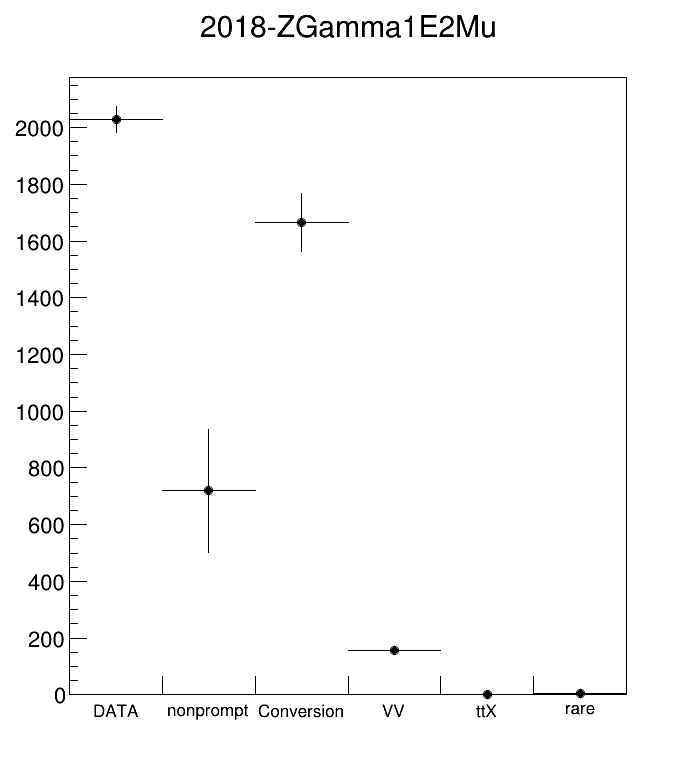

In [113]:
c = ROOT.TCanvas("", "", 700, 800)
c.cd()
RatesWithError.Draw()
c.RedrawAxis()
c.Draw()

In [114]:
# Now measure the conversion SF
rate_data = RatesWithError.GetBinContent(1)
rate_conv = RatesWithError.GetBinContent(3)
rate_pred = RatesWithError.GetBinContent(2) + RatesWithError.GetBinContent(4) + RatesWithError.GetBinContent(5) + RatesWithError.GetBinContent(6)

dsf_ddata = 1 / rate_conv
dsf_dconv = - (rate_data - rate_pred) / pow(rate_conv, 2)
dsf_dpred = -1 / rate_conv

sf = (rate_data - rate_pred) / rate_conv
sf_err = sqrt(pow(dsf_ddata*RatesWithError.GetBinError(1), 2) + pow(dsf_dconv*RatesWithError.GetBinError(3), 2) + pow(dsf_dpred*(RatesWithError.GetBinError(2) + RatesWithError.GetBinError(4) + RatesWithError.GetBinError(5) + RatesWithError.GetBinError(6)), 2))

print(sf, sf_err, sf_err/sf)

0.6896867955935336 0.14404872542264927 0.2088610748284418
